# IT3103 Assignment 1

### Importing the necessary libraries

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import numpy as np

### Importing the dataset
Imports the datasets to be used when training the model

In [5]:
# Get the file from the link
dataset_URL = 'https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/datasets/fruits.zip'

# Extract the file into a folder
path_to_zip = tf.keras.utils.get_file('fruits.zip', origin=dataset_URL, extract=True, cache_dir='.')

# Set the path to look for the files
dataset_dir = os.path.join(os.path.dirname(path_to_zip), "fruits_extracted/fruits")
dataset_dir_valid = os.path.join(os.path.dirname(path_to_zip), "fruits_extracted/fruits")

### Extracting datasets 
Extracting the datasets into the training dataset and the valid test dataset

In [7]:
# Training Directory
trainingDirectory = os.path.join(dataset_dir, "train")

# Validation Directory
validationDirectory = os.path.join(dataset_dir_valid, "valid")

### Creating the Model
Model will be created with:
- Data Augmentation
    - Random Flips (Horizontal and Vertical)
    - Random Rotations
    - Random Zoom
- 4 Convolutional Layers with a 2x2 Max Pooling Layer
- 2 Hidden Layers
    - 512 and 256 neurons respectively
    - Drop out of 0.3 per hidden layer

In [9]:
def make_model():
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(128,128, 3)))
    model.add(keras.layers.Rescaling(1./255))

    # Data Augmentation
    model.add(keras.layers.RandomFlip("horizontal_and_vertical"))
    model.add(keras.layers.RandomRotation(0.3))
    model.add(keras.layers.RandomZoom(0.3))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(6, activation="softmax"))

    return model

model = make_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,510 (10.43 MB)

 Trainable params: 2,733,510 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

None


### Adding Optimizer and Loss Function
The loss function used will be "Sparse Categorical Crossentropy" as the labels used are integers  
The optimizer used will be ADAM with a learning rate of 1e-4  
The metric used will be Accuracy so that our predictions will be as accurate as possible

In [29]:
# Sparse Categorical Crossentropy is used when truth labels are integer coded and have multiple classes
# Categorical Crossentropy is used when it is one hot coded
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

### Data Preprocessing
The steps for Data Preprocessing for our group is as follows:
- Changing all images to a standard 128*128 image size
- Setting the batch size to 32

In [13]:
imgHeight, imgWidth = 128, 128
batchSize = 32

# Resizing all images into the smae size
imageSize = (imgHeight, imgWidth)

trainingDataset = keras.preprocessing.image_dataset_from_directory(
    trainingDirectory,
    seed=1,
    image_size=imageSize,
    batch_size=batchSize,
    label_mode="int"
)

validationDataset = keras.preprocessing.image_dataset_from_directory(
    validationDirectory,
    seed=1,
    image_size=imageSize,
    batch_size=batchSize,
    label_mode="int"
)

for images, labels in trainingDataset.take(1):
    print("Images Shape: ", images.shape)
    print("Labels Shape: ", labels.shape)
    print(tf.squeeze(labels))

# print out the indices to find out the class
print(trainingDataset.class_names)
print(validationDataset.class_names)

Found 1182 files belonging to 6 classes.
Found 329 files belonging to 6 classes.
Images Shape:  (32, 128, 128, 3)
Labels Shape:  (32,)
tf.Tensor([2 3 0 3 4 3 4 4 1 2 4 0 4 1 2 1 3 5 1 3 2 5 1 3 4 3 3 0 3 0 0 0], shape=(32,), dtype=int32)
['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


### Training the Model
When creating the model, we also included a function to create a Tensorboard once the model has finished training.  
As for the model itself, we decided to train it for 40 epochs to increase the accuracy slightly from the previous 30 epochs.

In [15]:
def create_tb_callback():
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():
        import time
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="bestcheckpoint.weights.h5",
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

model.fit(
    trainingDataset,
    epochs=40,
    validation_data=validationDataset,
    callbacks=[create_tb_callback(), model_checkpoint_callback]
)

Epoch 1/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.2412 - loss: 1.7600 - val_accuracy: 0.3830 - val_loss: 1.5341
Epoch 2/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.4144 - loss: 1.4719 - val_accuracy: 0.4742 - val_loss: 1.2460
Epoch 3/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.4833 - loss: 1.2714 - val_accuracy: 0.6170 - val_loss: 1.0810
Epoch 4/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.5495 - loss: 1.1141 - val_accuracy: 0.6626 - val_loss: 0.9472
Epoch 5/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.6277 - loss: 0.9419 - val_accuracy: 0.5927 - val_loss: 0.9573
Epoch 6/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.6264 - loss: 0.8976 - val_accuracy: 0.7204 - val_loss: 0.8620
Epoch 7/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.7195 - loss: 0.7682 - val_accuracy: 0.7781 - val_loss: 0.7305
Epoch 8/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.7567 - loss: 0.6749 - val_accuracy

### Saving the Model and Displaying the Tensorboard
Model to be saved as "SavedModel.keras" as defined in the assignment.  
Loaded and displayed the tensorboard.

In [16]:
keras.models.save_model(model, filepath="SavedModel.keras")

In [9]:
%load_ext tensorboard
%tensorboard --logdir tb_logs --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Testing the Model
Testing the saved Model with several test images that were found on the internet.  
Test images are also scaled to a 128*128 image size, where afterward, it is converted into an array where it will be fed to the model.  
The model will then provide the predicted labels.

freshapples


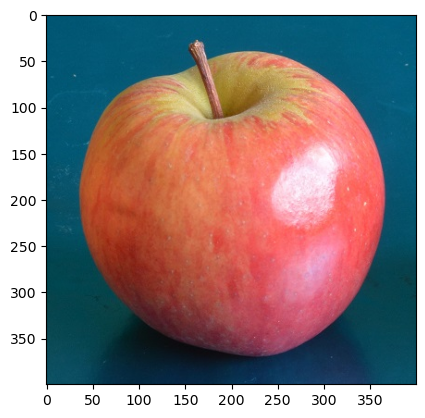

In [23]:
from enum import Enum
import matplotlib.image as mpimg

filename = "TestImages/apple.jpg"

img = mpimg.imread(filename)
imgplot = plt.imshow(img)


test_image = keras.preprocessing.image.load_img(
    filename, target_size=(128, 128)
)

# Converts the image to numpy array
img_array = keras.preprocessing.image.img_to_array(test_image)

img_array = tf.expand_dims(img_array, 0)

# Loading the model  to do the inference
model = tf.keras.models.load_model("SavedModel.keras")
predicted_label = model(img_array)

class FruitType(Enum):
    freshapples = 0
    freshbanana = 1
    freshoranges = 2
    rottenapples = 3
    rottenbanana = 4
    rottenoranges = 5

print(FruitType(np.argmax(predicted_label)).name)

In [ ]:
validationDataset.class_names